# load modules and 99.25% accuracy CNN for MNIST dataset

In [97]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np
import PIL
from scipy.special import softmax
import tensorflow as tf
from keras.models import load_model
from keras import backend as K
tf.logging.set_verbosity(tf.logging.ERROR)
tf.logging.set_verbosity(tf.logging.WARN)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

def load_image(image_location):
    x = np.asarray(PIL.Image.open(image_location))
    x = x.reshape(28,28)
    x = x.reshape(1, 28, 28, 1)
    x = x.astype('float32')
    x /= 255
    return x

model = load_model('/Users/zetong/cnn.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

# define the loss

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x158cc3f60>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


9


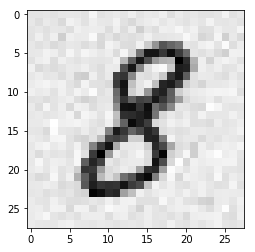

In [99]:
x_new = tf.Variable(np.zeros([1,28,28,1]), dtype=tf.float32)
logits = model(x_new)
target = 9
k = 0
c = 1000
x = load_image('/Users/zetong/mnist_png/testing/8/110.png')
nontarget_logits = newlogits = tf.concat([logits[0][0:target], logits[0][target:-1]], 0)
loss = tf.norm(x_new-x)**2 + c*tf.math.maximum(tf.math.reduce_max(nontarget_logits) - logits[0][target], -k)
train = tf.train.AdamOptimizer(0.1).minimize(loss, var_list=[x_new])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        #print(sess.run(loss))
        sess.run(train)
        new_img = sess.run(x_new)
        #print(np.argmax(model.predict(new_img)))
    plt.imshow(new_img.reshape((28,28)), cmap='Greys')
    print(np.argmax(model.predict(new_img)))

In [117]:
def targeted_attack(model, original_img, target_label, max_iteration=1000, step_size=0.1, c=100, k=0):
    x_new = tf.Variable(np.zeros([1,28,28,1]), dtype=tf.float32)
    logits = model(x_new)
    target = target_label
    x = original_img
    nontarget_logits = newlogits = tf.concat([logits[0][0:target], logits[0][target:-1]], 0)
    loss = tf.norm(x_new-x)**2 + c*tf.math.maximum(tf.math.reduce_max(nontarget_logits) - logits[0][target], -k)
    train = tf.train.AdamOptimizer(step_size).minimize(loss, var_list=[x_new])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(max_iteration):
            #print(sess.run(loss))
            sess.run(train)
            new_img = sess.run(x_new)
            #print(np.argmax(model.predict(new_img)))
        plt.imshow(new_img.reshape((28,28)), cmap='Greys')
        print(np.argmax(model.predict(new_img)))
        return sess.run(x_new)

def untargeted_attack(model, original_img, true_label, max_iteration=1000, step_size=0.1, c=100, k=0):
    attacks = []
    misclassified_labels = []
    # create adversarial example for each label
    for i in range(10):
        # don't have to create adversarial example for the true label
        if i == true_label:
            continue
        x_new = tf.Variable(np.zeros([1,28,28,1]), dtype=tf.float32)
        logits = model(x_new)
        target = i
        x = original_img
        nontarget_logits = newlogits = tf.concat([logits[0][0:target], logits[0][target:-1]], 0)
        loss = tf.norm(x_new-x)**2 + c*tf.math.maximum(tf.math.reduce_max(nontarget_logits) - logits[0][target], -k)
        train = tf.train.AdamOptimizer(step_size).minimize(loss, var_list=[x_new])
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(max_iteration):
                #print(sess.run(loss))
                sess.run(train)
                new_img = sess.run(x_new)
            prediction = np.argmax(model.predict(new_img))
            if prediction != true_label:
                attacks.append(new_img)
                misclassified_labels.append(prediction)
            sess.close()
    return attacks, misclassified_labels

# putting the adversarial examples and their misclassification labels in subplots
def plot_adversarials(attacks, predicted_labels):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = len(attacks)
    rows = 1
    for i in range(1, columns*rows+1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(str(predicted_labels[i-1]))
        plt.imshow(attacks[i-1].reshape((28,28)), cmap='Greys')
    plt.show()
    
# attack wrapper function
def attack(model, original_img, iterations=1000, eta=0.1, C=1000, K=0):
    true_label = np.argmax(model.predict(original_img))
    attacks, labels = untargeted_attack(model, x, true_label, max_iteration=iterations, step_size=eta, c=C, k=K)
    plot_adversarials(attacks, labels)

# a helper function to visualize a list of adversarial examples
def visualize_adversarials(attacks):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = len(attacks)
    rows = 1
    for i in range(1, columns*rows+1):
        ax = fig.add_subplot(rows, columns, i)
        plt.imshow(attacks[i-1].reshape((28,28)), cmap='Greys')
    plt.show()

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x154cc74a8>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x156622e48>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._sess

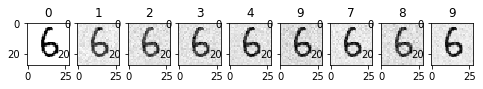

In [96]:
x = load_image('/Users/zetong/mnist_png/testing/6/21.png')
attack(model, x)

In [196]:
# search for the best adversarial examples
def find_best_attack(model, original_img, target_label, max_iterations=1000, step_size=0.1, SEARCH_STEPS=9):
    # all the valid attacks
    attacks = []
    # initial c value
    c = 1
    for s in range(SEARCH_STEPS):
        x_new = tf.Variable(np.zeros([1,28,28,1]), dtype=tf.float32)
        logits = model(x_new)
        target = target_label
        x = original_img
        nontarget_logits = newlogits = tf.concat([logits[0][0:target], logits[0][target:-1]], 0)
        loss = tf.norm(x_new-x)**2 + c*tf.math.maximum(tf.math.reduce_max(nontarget_logits) - logits[0][target], -k)
        train = tf.train.AdamOptimizer(step_size).minimize(loss, var_list=[x_new])
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(max_iterations):
                sess.run(train)
                new_img = sess.run(x_new)
            # if the attack is sucessful
            if np.argmax(model.predict(new_img)) == target_label:
                # add it to the valid attacks collection
                attacks.append(new_img)
                # decrease c value to try to find an attack with less perturbation
                c = c*0.5
            # if the attack failed
            else:
                # increase c value to enforce the solver to find a sucessful attack
                c = c*10
    noise_norms = []
    for i in range(len(attacks)):
        noise_norms.append(np.linalg.norm(attacks[i] - x))
    best_attack = attacks[np.argmin(noise_norms)]
    return best_attack, attacks

In [197]:
x = load_image('/Users/zetong/mnist_png/testing/5/52.png')
best_attack, attacks = find_best_attack(model, x, 9)

FailedPreconditionError: Attempting to use uninitialized value beta2_power_281
	 [[node beta2_power_281/read (defined at <ipython-input-196-0cd89956229d>:16)  = Identity[T=DT_FLOAT, _class=["loc:@Adam_281/Assign_1"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](beta2_power_281)]]

Caused by op 'beta2_power_281/read', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-197-de00156ec5ea>", line 2, in <module>
    best_attack, attacks = find_best_attack(model, x, 9)
  File "<ipython-input-196-0cd89956229d>", line 16, in find_best_attack
    train = tf.train.AdamOptimizer(step_size).minimize(loss, var_list=[x_new])
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 410, in minimize
    name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 593, in apply_gradients
    self._create_slots(var_list)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 131, in _create_slots
    colocate_with=first_var)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 814, in _create_non_slot_variable
    v = variable_scope.variable(initial_value, name=name, trainable=False)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1329, in __init__
    constraint=constraint)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1491, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 81, in identity
    return gen_array_ops.identity(input, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3454, in identity
    "Identity", input=input, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta2_power_281
	 [[node beta2_power_281/read (defined at <ipython-input-196-0cd89956229d>:16)  = Identity[T=DT_FLOAT, _class=["loc:@Adam_281/Assign_1"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](beta2_power_281)]]


In [185]:
model.predict(best_attack)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x16abbf6a0>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


array([[6.86385790e-13, 1.02959294e-13, 1.60272017e-14, 7.48233902e-08,
        1.40493875e-11, 9.99999166e-01, 1.33140688e-07, 2.59020669e-11,
        1.64765612e-09, 5.59621299e-07]], dtype=float32)

In [118]:
noise_norms = []
for i in range(len(attacks)):
    noise_norms.append(np.linalg.norm(attacks[i] - x))

In [176]:
x = load_image('/Users/zetong/mnist_png/testing/5/52.png')
(np.linalg.norm(best_attack - x))


6.34565e-08

In [122]:
noise_norms

[2.2784538, 4.850643, 4.237538, 5.207149, 5.883292]